In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Read the data
langs = ['en','cs','de']
steps_epoch_mapping = {5: 500, 10: 1000, 15: 1500, 20: 2000, 25: 2500, 30: 3000, 35: 3500, 40: 4000}
epoch_steps_mapping = {v:k for k,v in steps_epoch_mapping.items()}
steps = steps_epoch_mapping.values()
kind = ['noisevignere3', 'noiseconstenigma']
evaldatasets = {lang:f'final_eval_dataset_{lang}.csv'  for lang in langs}
vignere_losses = {lang:f'{lang}_vignere_loss.csv'  for lang in langs}
enigmas = {lang:f'{lang}_enigma_loss.csv'  for lang in langs}
eval_col='eval_loss'

def vignerecol_name(lang, epoch):
    return f'{lang}_noisevignere3_{steps_epoch_mapping[epoch]}_cer'

def enigmacol_name(lang, epoch):
    return f'{lang}_noiseconstenigma_{steps_epoch_mapping[epoch]}_cer'
data_dfs: dict[str,pd.DataFrame] = {lang:pd.read_csv(evaldatasets[lang]) for lang in langs}
def proportion_of_chars(s, chars):
    return sum(c in chars for c in s) / len(s)
# additional static features
for data in data_dfs.values():
    data['e_pct'] = data['text'].apply(lambda x: proportion_of_chars(x, 'e'))
    data['spaces_pct'] = data['text'].apply(lambda x: proportion_of_chars(x, ' '))
    data['rare_letter_pct'] = data['text'].apply(lambda x: proportion_of_chars(x, 'xqjz'))
    data['text_length'] = data['text'].apply(len)


enigmaevolution_columns = {lang: [enigmacol_name(lang, epoch) for epoch in steps_epoch_mapping.keys()] for lang in langs}
vignereevolution_columns = {lang: [vignerecol_name(lang, epoch) for epoch in steps_epoch_mapping.keys()] for lang in langs}

In [20]:

import seaborn as sns
import matplotlib.pyplot as plt

def corr_matrix(lang:str, kind='vignere',checkpoint_indices=[0,2,5,7], method='pearson', save=None):
  with plt.style.context(['seaborn-v0_8-white','seaborn-v0_8-notebook']):
    # plt.rcParams['font.family']= 'Libertinus Sans'
    data = data_dfs[lang]
    numerical_df = data.select_dtypes(include=[np.number])
    corr_matrix_cols =[]
    if kind == 'vignere':
        kind_cols = vignereevolution_columns
    else:
        kind_cols = enigmaevolution_columns
    for i in checkpoint_indices:
        corr_matrix_cols.append(kind_cols[lang][i])
        # rename cipher from '{lang}_{noiseconstenigma/noisevignere depending on kind}_{step}_cer to '{lang}_{kind}_ep{n}_cer'
    corr_matrix_cols.extend(['bigram_js_divergence', 'depth_of_parse_tree',
                    'gpt2_perplexity', 'gpt2_tokens_per_char', 'named_entities',
                    'pos_bigram_js_divergence', 'pos_js_divergence',
                    'unigram_js_divergence', 'spaces_pct', 'e_pct', 'rare_letter_pct', 'text_length'])
    
    numerical_df = numerical_df[corr_matrix_cols]
    for i in checkpoint_indices:
    # rename from '{lang}_{noiseconstenigma/noisevignere depending on kind}_{step}_cer to '{lang}_{kind}_ep{n}_cer'
        numerical_df.rename(columns={kind_cols[lang][i]: f'Ep {epoch_steps_mapping[list(epoch_steps_mapping.keys())[i]]} CER'}, inplace=True)

    # rename js_divergence to js_div
    # rename depth of parse tree to dep_tree_depth
    numerical_df.rename(columns={'bigram_js_divergence': 'CharBgrmJSD',
                                'pos_bigram_js_divergence': 'PoSBgrmJSD',
                                'pos_js_divergence': 'PoSJSD',
                                'unigram_js_divergence': 'CharJSD',
                                'depth_of_parse_tree': 'TreeDepth',
                                'gpt2_tokens_per_char': 'GPT2Tok',
        'gpt2_perplexity': 'GPT2Ppx',
        'named_entities': 'NamedEnt',
        'spaces_pct': 'SpacePct',
        'e_pct': 'EPct',
        'rare_letter_pct': 'RarePct',
        'text_length': 'TextLen'

                                }
                                , inplace=True)
    # Calculating the correlation matrix
    

    correlation_magnitude_matrix = numerical_df.corr(method=method)


    # Printing the correlation matrix
    plt.figure(figsize=(10, 8)) # Adjust the size as neededp
    #descriptions of cols top and left
    sns.heatmap(correlation_magnitude_matrix, annot=True, fmt=".2f", cmap='seismic',center=0.0, linewidths=.5, )
    plt.xticks(rotation=45, ha='right', rotation_mode='anchor')

    name = 'Vig' if kind == 'vignere' else 'Enigma'
    # lang_name = 'English' if lang == 'en' else 'Czech' if lang == 'cs' else 'German'
    lang_name= lang.upper()
    plt.title(f'{lang_name}_{name} Correlation of Properties and Evaluation CER')
    if save:
        plt.savefig(save,bbox_inches='tight')
    plt.show()

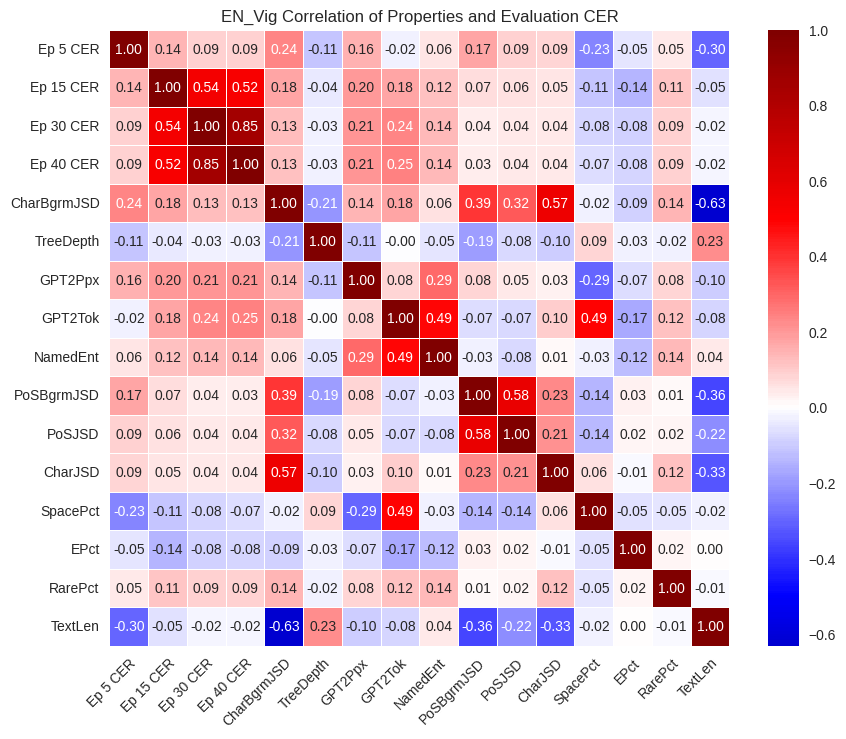

In [21]:

corr_matrix('en', kind='vignere', )

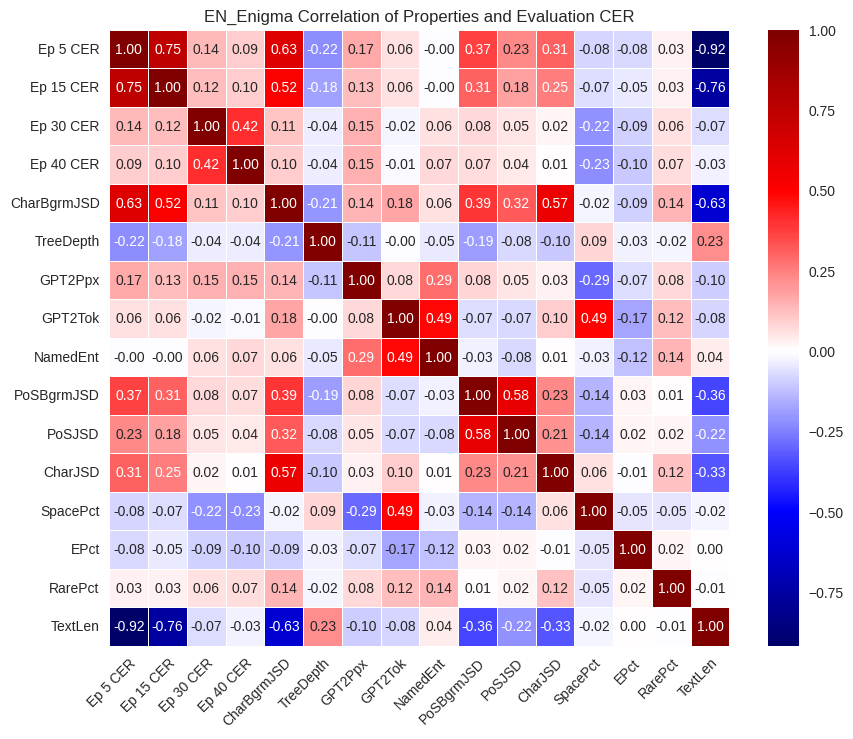

In [22]:
corr_matrix('en', kind='enigma', save='../img/en_enigma_corr.pdf')


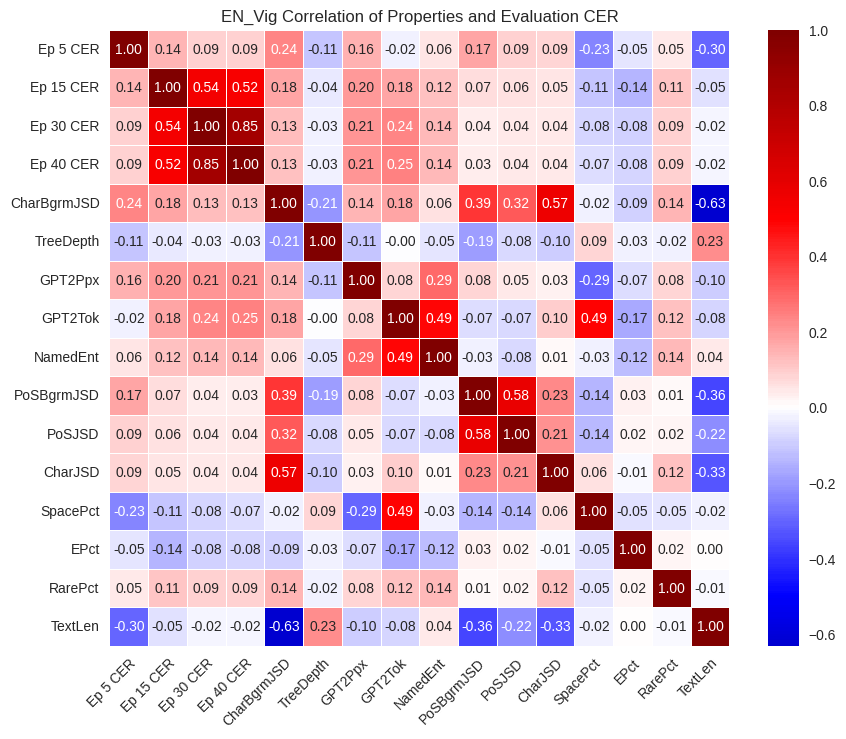

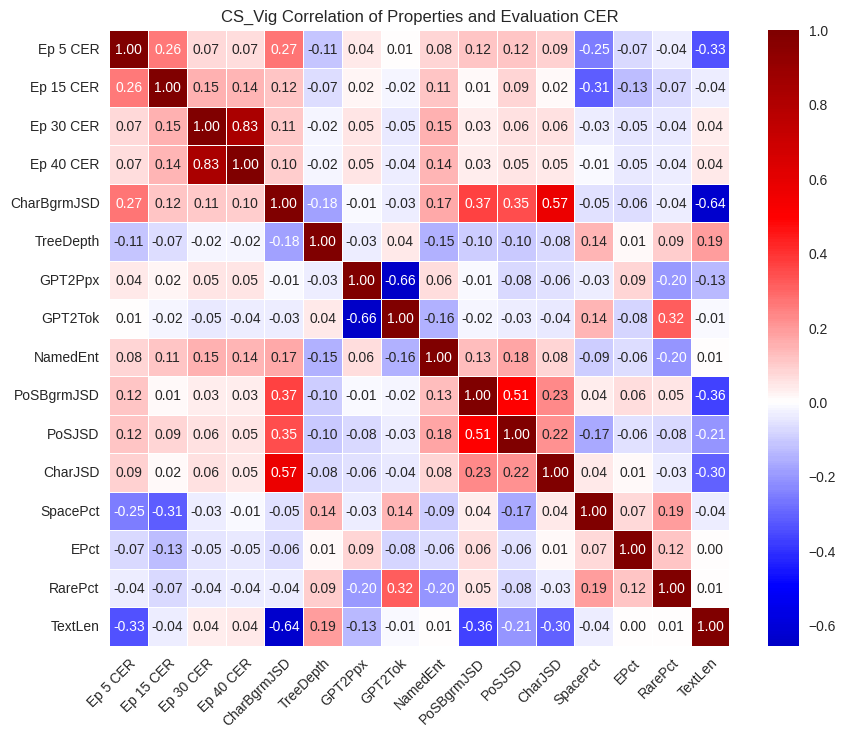

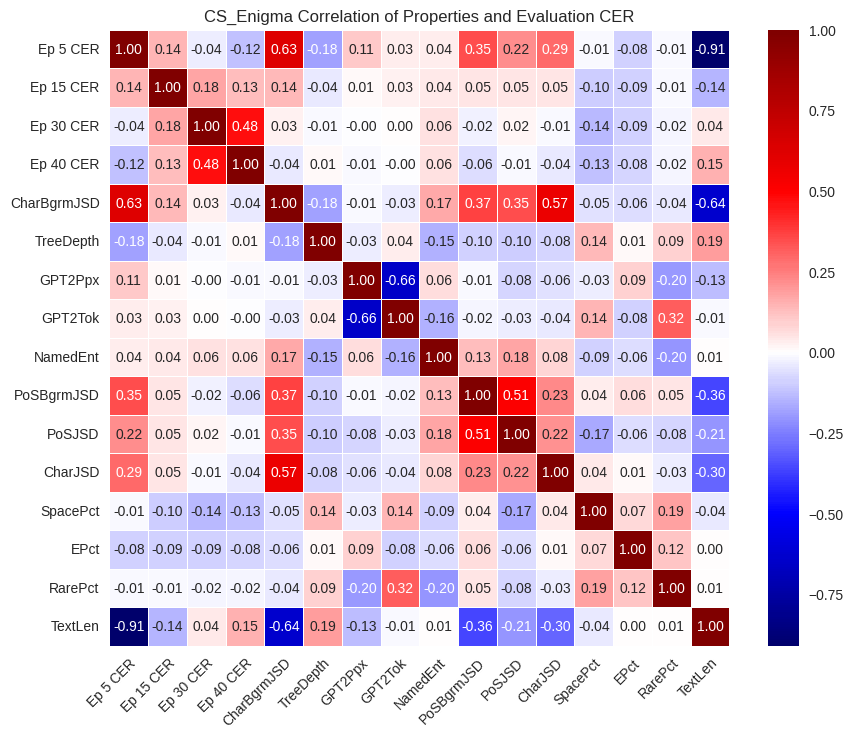

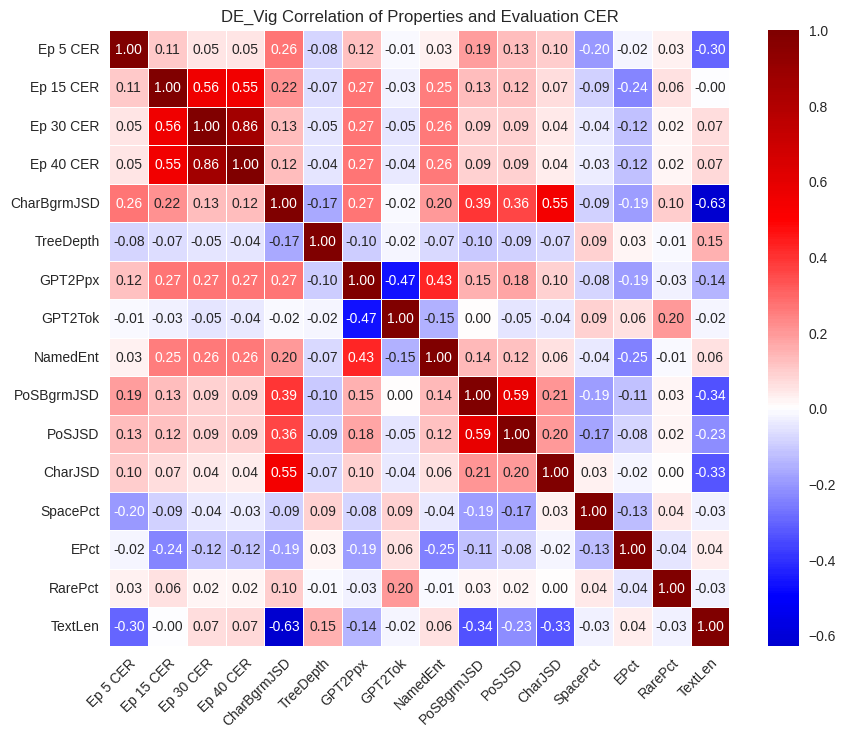

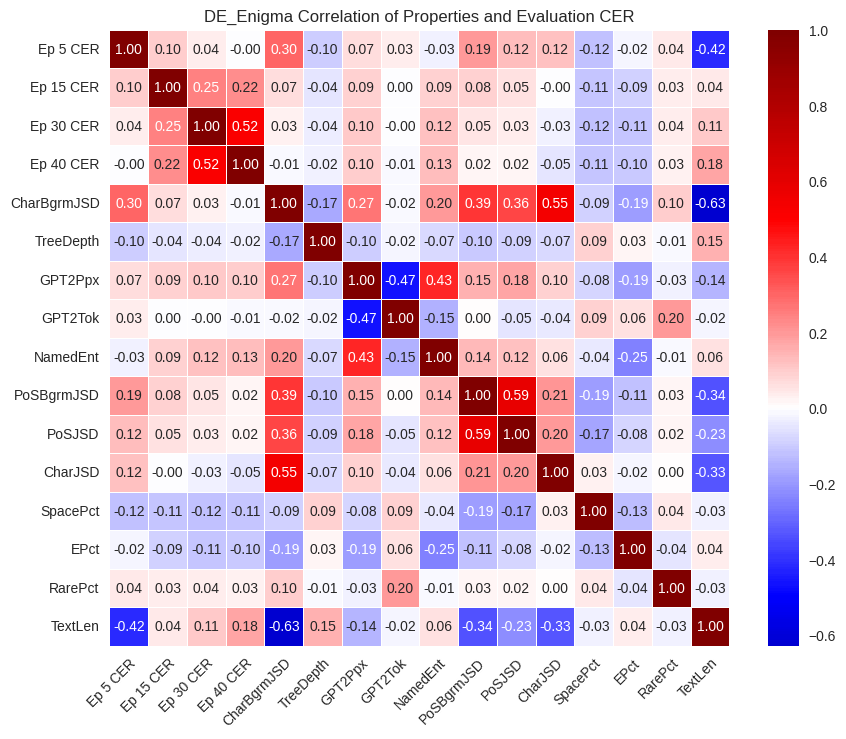

In [23]:

corr_matrix('en', kind='vignere', save='../img/en_vignere_corr.pdf')
corr_matrix('cs', kind='vignere', save='../img/cs_vignere_corr.pdf')
corr_matrix('cs', kind='enigma', save='../img/cs_enigma_corr.pdf')
corr_matrix('de', kind='vignere', save='../img/de_vignere_corr.pdf')
corr_matrix('de', kind='enigma', save='../img/de_enigma_corr.pdf')